<a href="https://colab.research.google.com/github/manami-bunbun/ES_analysis/blob/main/ES_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 就職活動ES

### テキストファイル読み込み

### インストール

In [190]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3==0.996.5
!pip install unidic-lite
!pip install japanize-matplotlib

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 4.1 MB 13.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl si

In [27]:
import MeCab
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 前処理

### 1.1. 形態素解析

文などを分割して、言語で意味を持つ最小単位である形態素の列に変換し、その品詞を推定することを形態素解析と呼びます。

In [42]:
tagger = MeCab.Tagger('-Ochasen')
node = tagger.parse("デジタルコンサルタント職では、常に最新のデジタルテクノロジーを学び、活用することができるからです。")
print(node)

デジタル	デジタル	デジタル	名詞-一般		
コンサルタント	コンサルタント	コンサルタント	名詞-一般		
職	ショク	職	名詞-接尾-一般		
で	デ	で	助詞-格助詞-一般		
は	ハ	は	助詞-係助詞		
、	、	、	記号-読点		
常に	ツネニ	常に	副詞-一般		
最新	サイシン	最新	名詞-一般		
の	ノ	の	助詞-連体化		
デジタル	デジタル	デジタル	名詞-一般		
テクノロジー	テクノロジー	テクノロジー	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
学び	マナビ	学ぶ	動詞-自立	五段・バ行	連用形
、	、	、	記号-読点		
活用	カツヨウ	活用	名詞-サ変接続		
する	スル	する	動詞-自立	サ変・スル	基本形
こと	コト	こと	名詞-非自立-一般		
が	ガ	が	助詞-格助詞-一般		
できる	デキル	できる	動詞-自立	一段	基本形
から	カラ	から	助詞-接続助詞		
です	デス	です	助動詞	特殊・デス	基本形
。	。	。	記号-句点		
EOS



### 1.2. MeCabを用いて文を形態素に分割

先ほどの形態素解析の結果を用いて、日本語の文を形態素に分割する関数を定義します。

In [224]:
def tokenize(sentence):
    """日本語の文を形態素の列に分割する関数

    :param sentence: str, 日本語の文
    :return tokenized_sentence: list of str, 形態素のリスト
    """
    node = tagger.parse(sentence)
    node = node.split("\n")
    tokenized_sentence = []
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            # 文が終わったら終了
            break
        elif not(feature[0] == "、" or feature[0] == "。" or feature[0] == " ") :
           if  feature[3].startswith(('形容詞', '名詞')):
        # 分割された形態素を追加
                print(feature)
                tokenized_sentence.append(feature[0])
    return tokenized_sentence

In [225]:
tokenize("坊主が屏風に上手に坊主の絵を描いた")

['坊主', 'ボウズ', '坊主', '名詞-一般', '', '']
['屏風', 'ビョウブ', '屏風', '名詞-一般', '', '']
['上手', 'ジョウズ', '上手', '名詞-形容動詞語幹', '', '']
['坊主', 'ボウズ', '坊主', '名詞-一般', '', '']
['絵', 'エ', '絵', '名詞-一般', '', '']


['坊主', '屏風', '上手', '坊主', '絵']

In [226]:
def load_data(path):
    """読み込むための関数

    :param path: str, パス
    :return text: list of list of str, 各文がトークナイズされた
    """
    text = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            line = tokenize(line)
            text.append(line)
    return text

In [227]:
text = load_data('Data_consultant.txt')

['デジタル', 'デジタル', 'デジタル', '名詞-一般', '', '']
['コンサルタント', 'コンサルタント', 'コンサルタント', '名詞-一般', '', '']
['職', 'ショク', '職', '名詞-接尾-一般', '', '']
['最新', 'サイシン', '最新', '名詞-一般', '', '']
['デジタル', 'デジタル', 'デジタル', '名詞-一般', '', '']
['テクノロジー', 'テクノロジー', 'テクノロジー', '名詞-一般', '', '']
['活用', 'カツヨウ', '活用', '名詞-サ変接続', '', '']
['こと', 'コト', 'こと', '名詞-非自立-一般', '', '']
['私', 'ワタシ', '私', '名詞-代名詞-一般', '', '']
['大学', 'ダイガク', '大学', '名詞-一般', '', '']
['情報', 'ジョウホウ', '情報', '名詞-一般', '', '']
['系', 'ケイ', '系', '名詞-接尾-一般', '', '']
['主', 'オモ', '主', '名詞-形容動詞語幹', '', '']
['それら', 'ソレラ', 'それら', '名詞-代名詞-一般', '', '']
['魅力', 'ミリョク', '魅力', '名詞-一般', '', '']
['今後', 'コンゴ', '今後', '名詞-副詞可能', '', '']
['可能', 'カノウ', '可能', '名詞-形容動詞語幹', '', '']
['性', 'セイ', '性', '名詞-接尾-一般', '', '']
['社会', 'シャカイ', '社会', '名詞-一般', '', '']
['人', 'ジン', '人', '名詞-接尾-一般', '', '']
['上', 'ウエ', '上', '名詞-非自立-副詞可能', '', '']
['新しい', 'アタラシイ', '新しい', '形容詞-自立', '形容詞・イ段', '基本形']
['技術', 'ギジュツ', '技術', '名詞-一般', '', '']
['姿勢', 'シセイ', '姿勢', '名詞-一般', '', '']
['大切', 'タイセツ', '大切', '名詞-形容動詞語幹

In [229]:
# 分割された結果の例
print(text)

[['デジタル', 'コンサルタント', '職', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', '私', '大学', '情報', '系', '主', 'それら', '魅力', '今後', '可能', '性', '社会', '人', '上', '新しい', '技術', '姿勢', '大切', '自身', '成長', 'ため', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', 'デジタル', 'コンサルタント', '職', '志望'], [], ['最先端', 'デジタル技術', '専門', '性', 'それ', '課題', '解決', '新た', '価値', '創造', '私', 'ゼミ', '研究', 'IoT', 'AI', '最先端', 'デジタル技術', '今後', '社会', '非常', '可能', '性', 'こと', '関心', 'ため', 'デジタル技術', '専門', '性', '顧客', '課題', '解決', '新しい', '社会', '変革', '寄与'], [], ['私', 'デジタル', 'コンサルタント', '一', '志望', '職種', '理由', '私', '貴社', '実現', 'こと', '最適', '職種', '私', '企業', '激しく', '変化', '時代', '対応', 'ため', 'デジタル', '化', '必須', 'ため', '最先端', 'デジタル', '幅広く', '高度', '知見', 'それら', '応用', '必要', 'それ', '普遍', '的', '方法', '論', '身', '顧客', '新た', '価値', '提供'], [], ['顧客', 'テクノロジー', '何', 'コンサルタント', '昨今', '社会', '情勢', 'テクノロジー', '活用', 'ＤＸ', '化', '推進', '私', '推進', 'テクノロジー', '手段', '目的', '危惧', '中', '顧客', 'テクノロジー', '何', '実現', 'の', '何', '必要', 'の', 'コンサルタント'], [], ['自身', '研究', '無限', '可能', '性', '実感', 'IT', '技術', '課題', '解決', 'こと', 

### 1.3. データ読み込み

データコンサルタント志望理由


### 1.4. 辞書構築
コーパス（文書データ）に登場する単語にユニークなIDを振るために辞書を構築します。

全ての単語を辞書に登録するとしばしば語彙数が膨大(1万〜100万)になりメモリが足りなくなることがあるので、

単語の出現頻度で足切りして辞書のサイズを制限するということをします。

NLPではほぼ必ず必要になる手順です。

In [230]:
class Vocab(object):
    def __init__(self, word2id={}):
        """
        word2id: 単語(str)をインデックス(int)に変換する辞書
        id2word: インデックス(int)を単語(str)に変換する辞書
        """
        self.word2id = dict(word2id)
        self.id2word = {v: k for k, v in self.word2id.items()}    
        
    def build_vocab(self, sentences, min_count=3):
        # 各単語の出現回数の辞書を作成する
        word_counter = {}
        for sentence in sentences:
            for word in sentence:
                word_counter[word] = word_counter.get(word, 0) + 1

        # min_count回以上出現する単語のみ語彙に加える
        for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
            if count < min_count:
                break
            _id = len(self.word2id)
            self.word2id.setdefault(word, _id)
            self.id2word[_id] = word 



In [231]:
#単語の数カウンと
sen = []
for row in range(len(text)):
    for col in range(len(text[row])):
        sen.append(text[row][col])


print(sen)

['デジタル', 'コンサルタント', '職', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', '私', '大学', '情報', '系', '主', 'それら', '魅力', '今後', '可能', '性', '社会', '人', '上', '新しい', '技術', '姿勢', '大切', '自身', '成長', 'ため', '最新', 'デジタル', 'テクノロジー', '活用', 'こと', 'デジタル', 'コンサルタント', '職', '志望', '最先端', 'デジタル技術', '専門', '性', 'それ', '課題', '解決', '新た', '価値', '創造', '私', 'ゼミ', '研究', 'IoT', 'AI', '最先端', 'デジタル技術', '今後', '社会', '非常', '可能', '性', 'こと', '関心', 'ため', 'デジタル技術', '専門', '性', '顧客', '課題', '解決', '新しい', '社会', '変革', '寄与', '私', 'デジタル', 'コンサルタント', '一', '志望', '職種', '理由', '私', '貴社', '実現', 'こと', '最適', '職種', '私', '企業', '激しく', '変化', '時代', '対応', 'ため', 'デジタル', '化', '必須', 'ため', '最先端', 'デジタル', '幅広く', '高度', '知見', 'それら', '応用', '必要', 'それ', '普遍', '的', '方法', '論', '身', '顧客', '新た', '価値', '提供', '顧客', 'テクノロジー', '何', 'コンサルタント', '昨今', '社会', '情勢', 'テクノロジー', '活用', 'ＤＸ', '化', '推進', '私', '推進', 'テクノロジー', '手段', '目的', '危惧', '中', '顧客', 'テクノロジー', '何', '実現', 'の', '何', '必要', 'の', 'コンサルタント', '自身', '研究', '無限', '可能', '性', '実感', 'IT', '技術', '課題', '解決', 'こと', '時代', '業界', '業種', 'IT', '

In [232]:
import collections
c = collections.Counter(sen)
print(c.most_common(20))

[('こと', 14), ('デジタル', 12), ('コンサルタント', 9), ('テクノロジー', 8), ('私', 7), ('性', 7), ('社会', 5), ('最新', 4), ('技術', 4), ('自身', 4), ('ため', 4), ('最先端', 4), ('専門', 4), ('課題', 4), ('解決', 4), ('顧客', 4), ('企業', 4), ('身', 4), ('の', 4), ('クライアント', 4)]


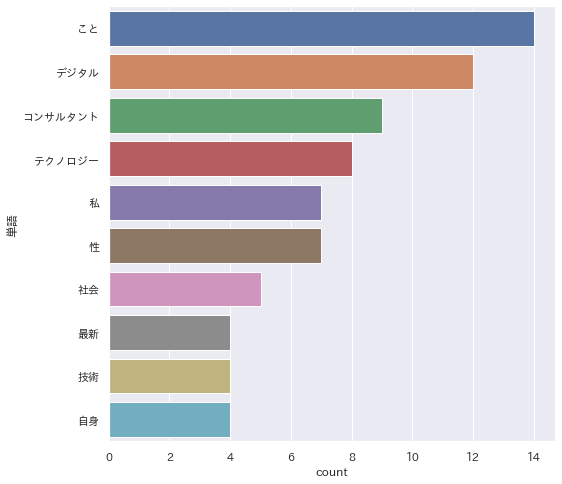

In [233]:
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt
 
sns.set(context="notebook",font='IPAexGothic')
fig = plt.subplots(figsize=(8, 8))
 
plt.ylabel("単語")
sns.countplot(y=sen,order=[i[0] for i in c.most_common(10)])

## デジタルコンサルタント

就職活動の軸